In [1]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from loguru import logger 
import rioxarray as rxr
import natsort

import warnings
warnings.filterwarnings("ignore")

In [2]:
images_train_path = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train"
images_train = natsort.natsorted(glob.glob(os.path.join(images_train_path, "*.tif"), recursive=False))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))

df = pd.read_csv("/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/answer.csv", header=None)
df.columns = ['file','target']
print("Target ### Total:  {}".format(len(df)))

IMAGES /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train ### Total:  1242
Target ### Total:  1242


In [3]:
df_train = pd.DataFrame()
df_train['image_path'] = images_train
df_train['target'] = df['target']
df_train['dataset']  = 'solafune'

In [4]:
df_train.head()

,image_path,target,dataset
0,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
1,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
2,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
3,/home/sebastien/Documents/projects/solafune-fi...,1,solafune
4,/home/sebastien/Documents/projects/solafune-fi...,0,solafune


In [5]:
df_train, df_val = train_test_split(df_train, test_size=0.10, random_state=42)
df_val, df_test  = train_test_split(df_val, test_size=0.20, random_state=42)

In [6]:
print("train data: {}".format(len(df_train)))
print("val data: {}".format(len(df_val)))
print("test data: {}".format(len(df_test)))

train data: 1117
val data: 100
test data: 25


In [7]:
# df_train.to_csv("../data_splits/train_path.csv")
# df_test.to_csv("../data_splits/test_path.csv")
# df_val.to_csv("../data_splits/valid_path.csv")

# Data exploration

In [10]:
data = rxr.open_rasterio(df_train['image_path'].iloc[-10], masked=False)
data

<xarray.DataArray (band: 12, y: 512, x: 512)>
[3145728 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 2.5 3.5 4.5 5.5 6.5 ... 510.5 511.5 512.5 513.5
  * y            (y) float64 2.5 3.5 4.5 5.5 6.5 ... 510.5 511.5 512.5 513.5
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B...

In [11]:
image = data.values
print(image.shape)

(12, 512, 512)


# Creating raw RGB composite

In [12]:
# RED -> Band 4 
# Green -> Band 3
# Blue -> Band 2 

red = image[3,:,:]
green = image[2,:,:]
blue = image[1,:,:]

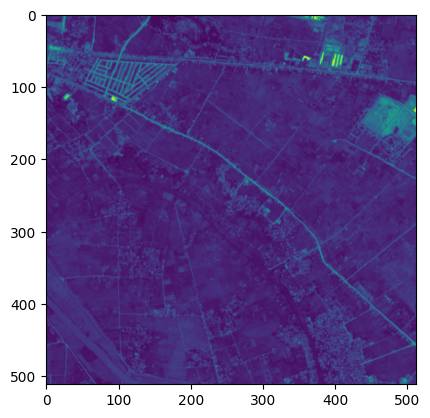

In [13]:
plt.imshow(red)

The blueish image is basically an intensity map, where each pixel represents the amount of reflected light that the Sentinel-2's sensor captured in the red band. The brighter pixels (higher values) represent more red content and the darker pixels (lower values) represent less red content.

We can change the blueish representation with the 'cmap' command. In the example below I choose 'Reds' representation.
(Note there are many other options as well. For more details please look ath the Matplotlib documentation).

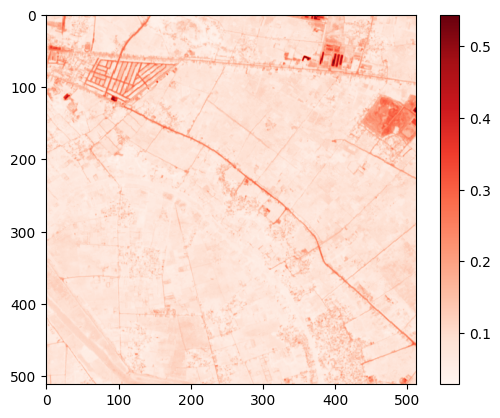

In [14]:
plt.imshow(red, cmap='Reds')
plt.colorbar()

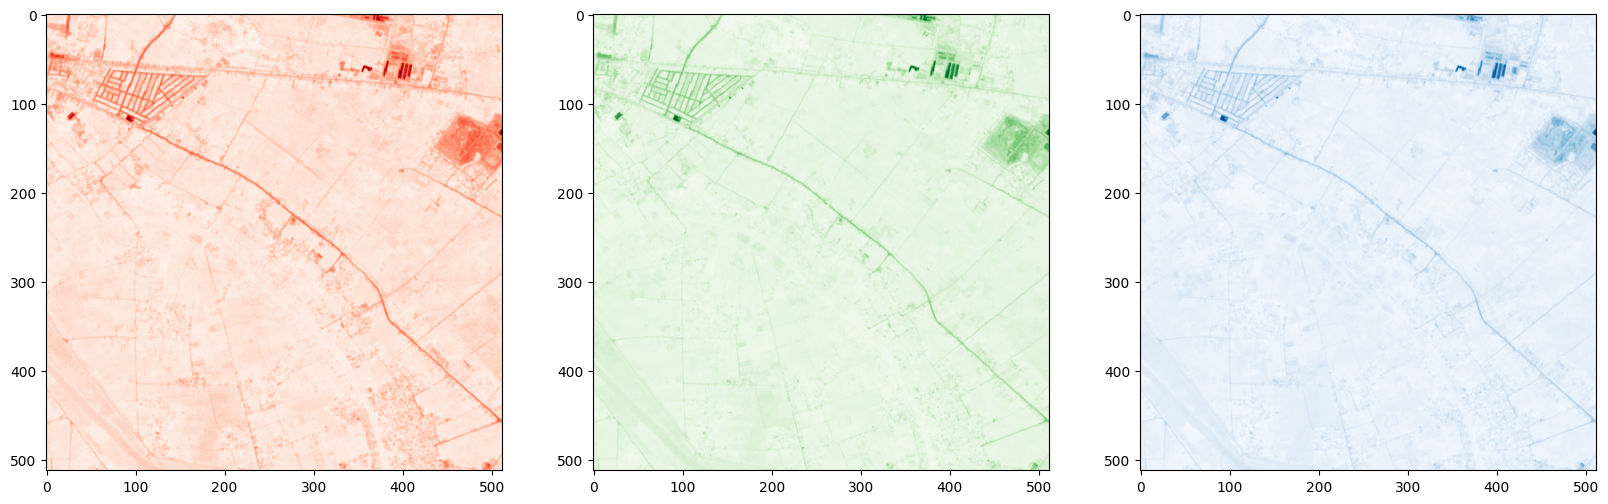

In [15]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(red, cmap='Reds')
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(green, cmap='Greens')
ax1 = fig.add_subplot(1,3,3)
ax1.imshow(blue, cmap='Blues')

To make an RGB composite we have to stack together the Red, Green and Blue band images into one image with the np.dstack command.
If we call again the shape command on the newly created RGB composite we will see, that now we got a 3D array with the red,green and blue channels.

In [16]:
rgb_composite_raw= np.dstack((red, green, blue))
rgb_composite_raw.shape

(512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


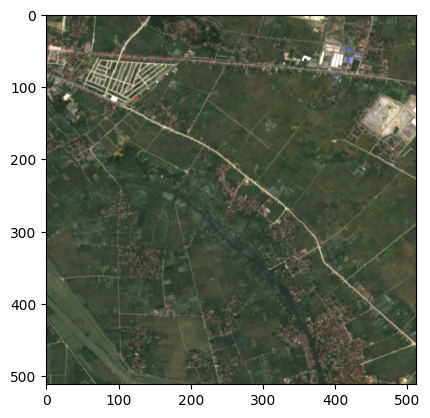

In [19]:
plt.imshow(rgb_composite_raw*3)

This is not quite what we are looking for, right? The root of the problem is that most images have a pixel value range from 0-255 or 0-1. If we look at the red band's max pixel value we get more than 255.

In [18]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)

In [17]:
red_n.max(), green_n.max(), blue_n.max()

(1.0, 1.0, 1.0)

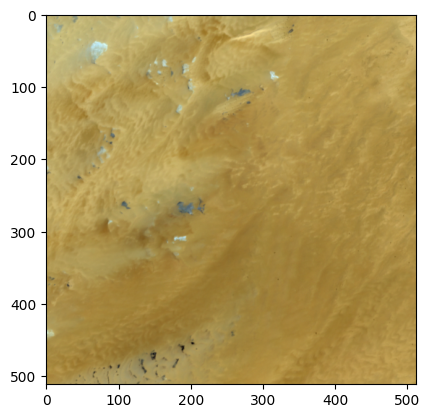

In [18]:
rgb_composite_n= np.dstack((red_n, green_n, blue_n))
plt.imshow(rgb_composite_n)

## Basic image manipulation techniques
To solve this issue, we will have to brighten each band first, then normalize them and do the stacking.
From mathematical point of view, the brightening function multiplies each pixel value with 'alpha' and adds 'beta' value if necessary.
If this operation is done we have to clip the resulted pixel values between 0..255.

In [19]:
def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)

red_b=brighten(red)
blue_b=brighten(blue)
green_b=brighten(green)

red_bn = normalize(red_b)
green_bn = normalize(green_b)
blue_bn = normalize(blue_b)

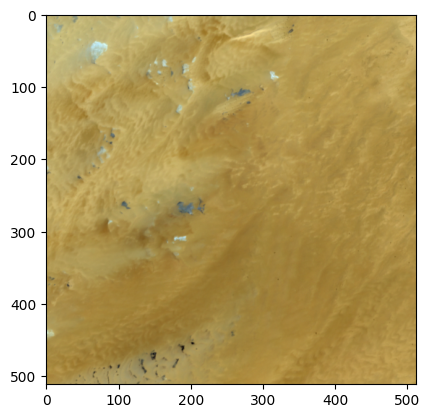

In [20]:
rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
plt.imshow(rgb_composite_bn)

Now our image is looking quite realistic now. Note that this image does not represent the real reflectance values.
Another image manipulation technique is gamma correction. The math behind it is that we take each pixels intesnity values and raise it to the power of (1/gamma) where the gamma value is specified by us.
Let's use our raw images, do the gamma correction and normalization.

In [21]:
def gammacorr(band):
    gamma=2
    return np.power(band, 1/gamma)

red_g=gammacorr(red)
blue_g=gammacorr(blue)
green_g=gammacorr(green)

red_gn = normalize(red_g)
green_gn = normalize(green_g)
blue_gn = normalize(blue_g)

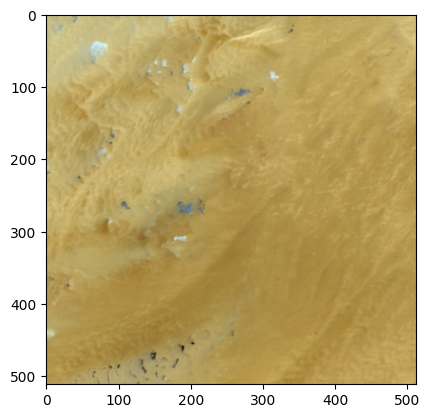

In [22]:
rgb_composite_gn= np.dstack((red_gn, green_gn, blue_gn))
plt.imshow(rgb_composite_gn)

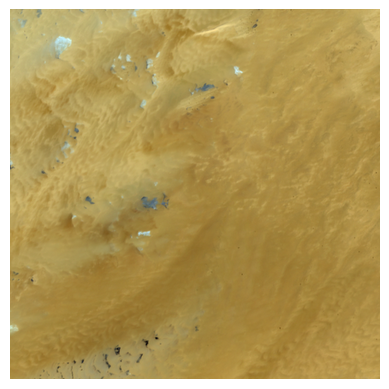

In [23]:
rgb_plot=plt.imshow(rgb_composite_bn, interpolation='lanczos')
plt.axis('off')
# plt.savefig('tihany_rgb_composite.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close('all')

In [24]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))


def image_preprocessing(image_path):

    image = rxr.open_rasterio(image_path, masked=False).values
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    return rgb_composite_n


def visualization(df,choice):
    
    random_choice = int(random.choice(np.arange(0,len(df),1)))

    image_path = df['image_path'].iloc[random_choice]
    image = rxr.open_rasterio(image_path, masked=False).values

    
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))

    print("image path {}".format(image_path))
    print("image {}".format(rgb_composite_n.shape))

    
    
    # Create a figure with subplots to display the images
    plt.figure(figsize=(15, 5))
    
    # Display the images
    plt.imshow(rgb_composite_n)
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()
    

image path /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_853.tif
image (512, 512, 3)


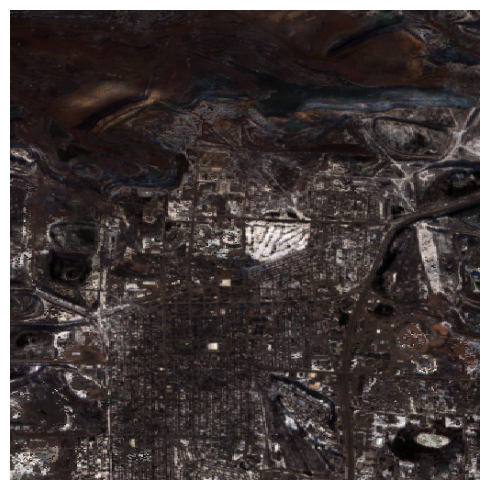

In [25]:
visualization(df_train,choice=19)

In [26]:
## Data Distribution

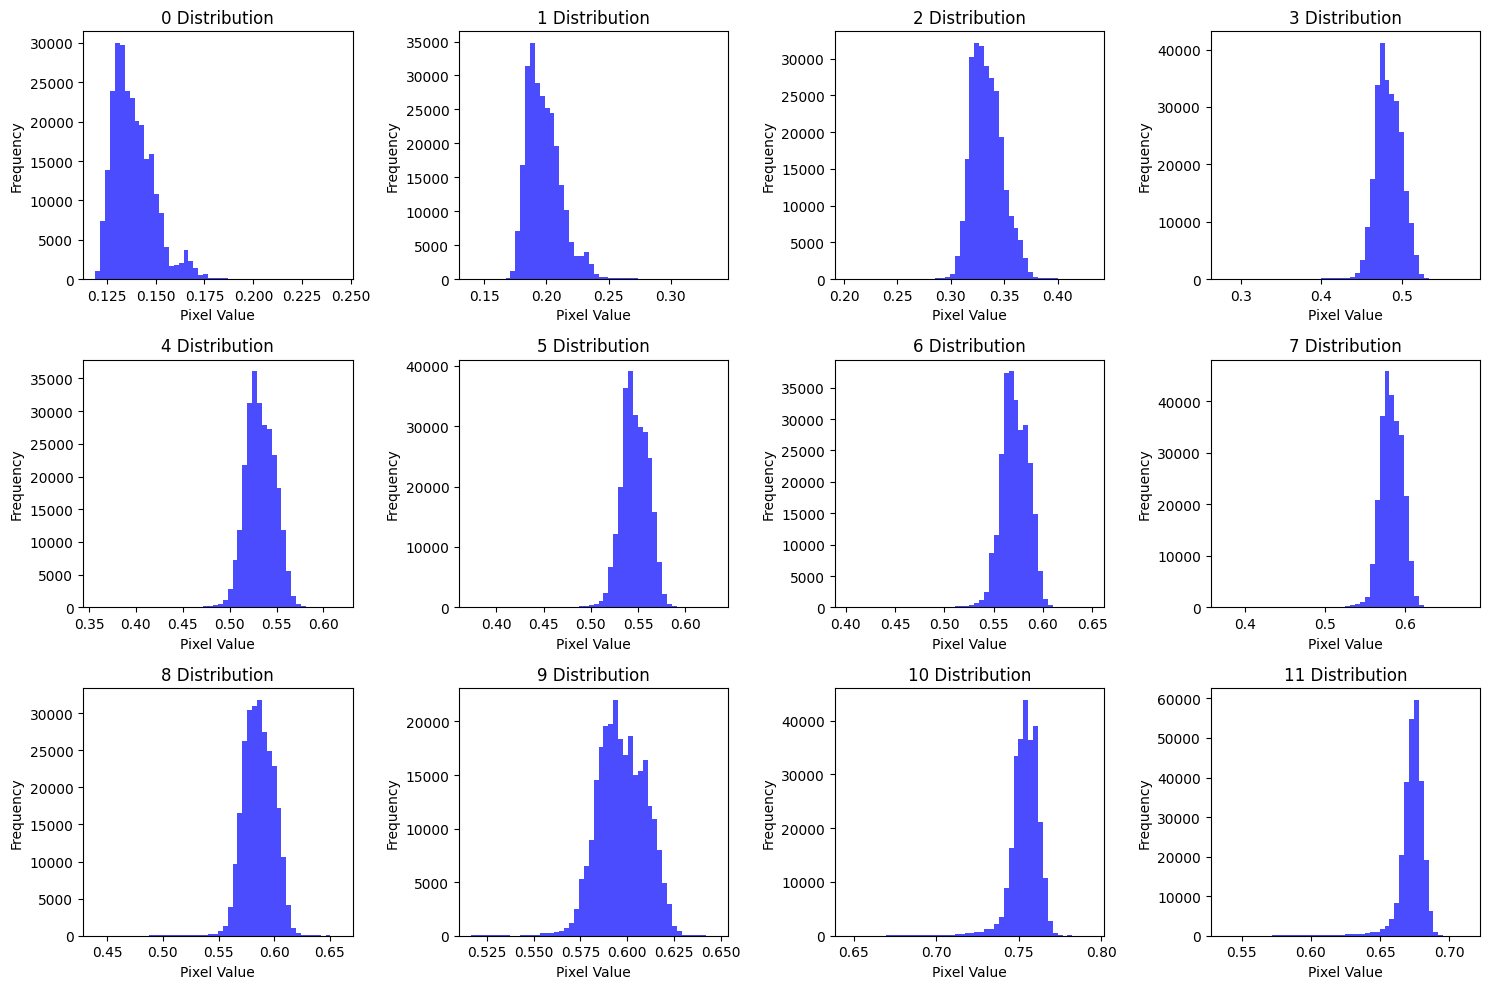

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have data for 12 bands (band_1, band_2, ..., band_12)
# Replace this with your actual data for each band
# For demonstration, generating random data between 0 and 100 for each band
num_bands = 12

data = rxr.open_rasterio(df_train['image_path'].iloc[-1], masked=False)



# Plotting histograms for each band
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axs = axs.flatten()

for band in range(12):
    axs[band].hist(data[band,:,:].values.flatten(), bins=50, color='blue', alpha=0.7)
    axs[band].set_title(f'{band} Distribution')
    axs[band].set_xlabel('Pixel Value')
    axs[band].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [28]:
path = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_718.tif"

In [29]:
data = rxr.open_rasterio(path, masked=False)
data

<xarray.DataArray (band: 12, y: 512, x: 512)>
[3145728 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 2.5 3.5 4.5 5.5 6.5 ... 510.5 511.5 512.5 513.5
  * y            (y) float64 2.5 3.5 4.5 5.5 6.5 ... 510.5 511.5 512.5 513.5
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B...

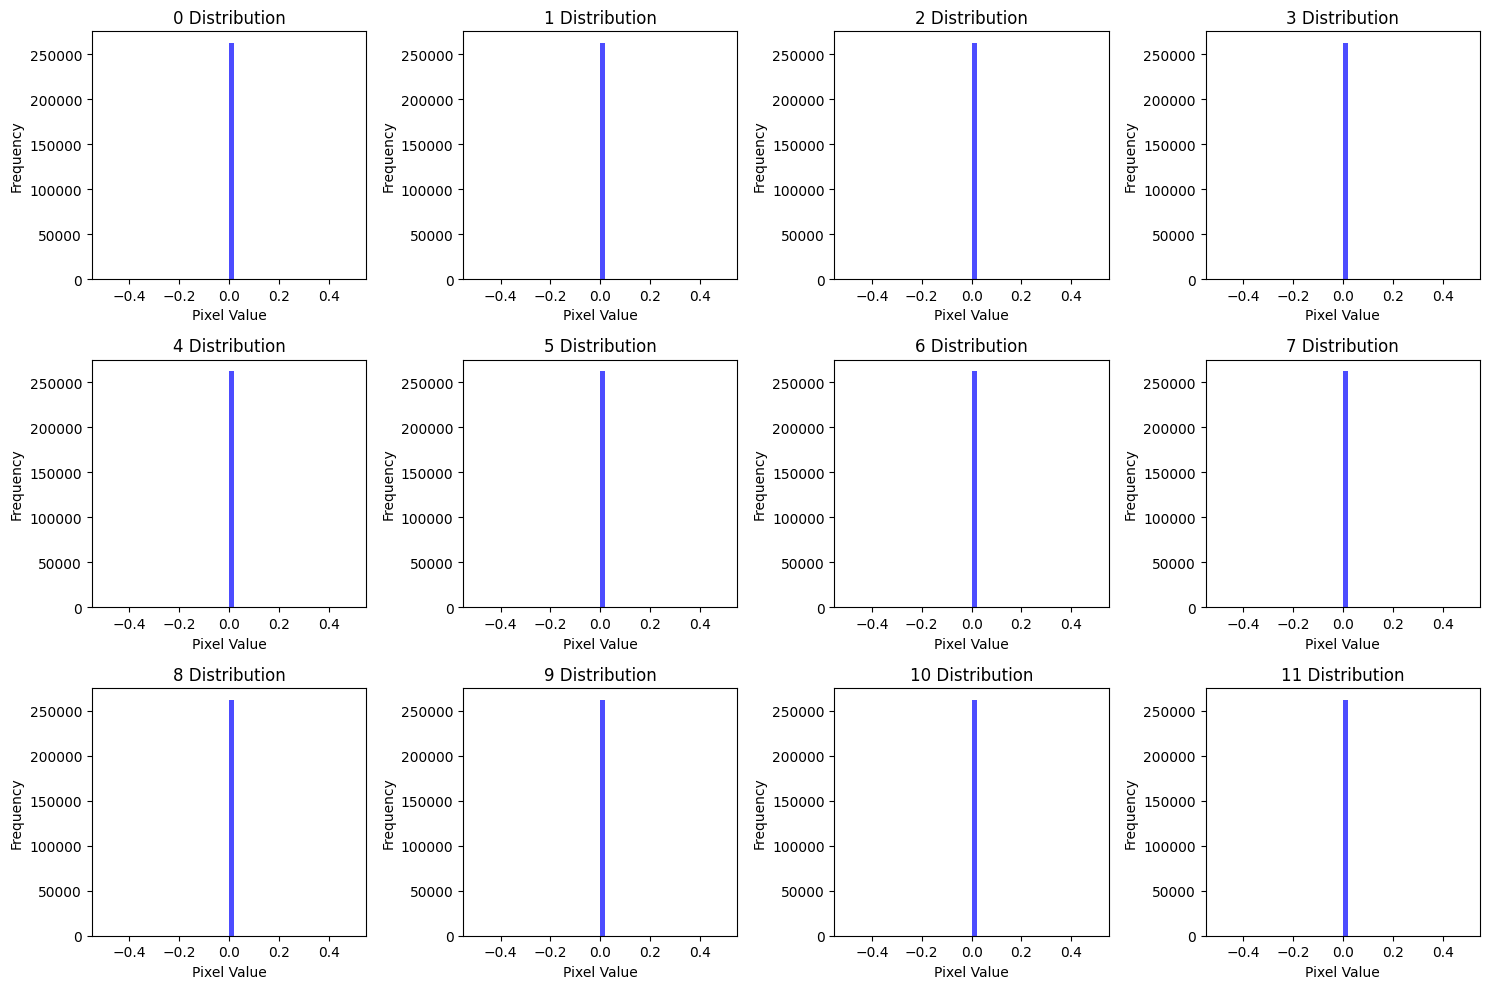

In [30]:
# Plotting histograms for each band
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axs = axs.flatten()

for band in range(12):
    axs[band].hist(data[band,:,:].values.flatten(), bins=50, color='blue', alpha=0.7)
    axs[band].set_title(f'{band} Distribution')
    axs[band].set_xlabel('Pixel Value')
    axs[band].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [32]:
## Clean Dataset

In [31]:
def check_all_zero_bands(image_path):
    image = rxr.open_rasterio(image_path, masked=False).values
    
    # Check if all bands in the image are zeros
    all_zero_bands = np.all(image == 0, axis=(1, 2))  # Check along the bands (axis=1 and axis=2)

    return all_zero_bands

In [32]:
images_train_path = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train"
images_train = natsort.natsorted(glob.glob(os.path.join(images_train_path, "*.tif"), recursive=False))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))

zero_bands_images = []
clean_images_path = []
for image_path in images_train:

    all_zero_bands = check_all_zero_bands(image_path)

    if np.all(all_zero_bands):  # If all bands are zeros
        print("All bands are zeros in:", image_path)
        zero_bands_images.append(os.path.basename(image_path))  
    else:

        clean_images_path.append(image_path)

IMAGES /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train ### Total:  1242
All bands are zeros in: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_718.tif
All bands are zeros in: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_788.tif
All bands are zeros in: /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_958.tif


In [33]:
print("IMAGES {} ### Total:  {}".format(images_train_path, len(clean_images_path)))

IMAGES /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train ### Total:  1239


In [35]:
df_filtered = df[~df['file'].isin(zero_bands_images)]
df_filtered = df_filtered.reset_index(drop=True)

In [36]:
for i in range(len(df_filtered)):
    path = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/"
    df_filtered['file'][i] = path + df_filtered['file'][i]

In [37]:
df_filtered
df_train = pd.DataFrame()
df_train['image_path'] = df_filtered['file']
df_train['target'] = df_filtered['target']

In [59]:
dfs

,image_path,target
0,/home/sebastien/Documents/projects/solafune-fi...,0
1,/home/sebastien/Documents/projects/solafune-fi...,0
2,/home/sebastien/Documents/projects/solafune-fi...,0
3,/home/sebastien/Documents/projects/solafune-fi...,1
4,/home/sebastien/Documents/projects/solafune-fi...,0
...,...,...
1234,/home/sebastien/Documents/projects/solafune-fi...,0
1235,/home/sebastien/Documents/projects/solafune-fi...,0
1236,/home/sebastien/Documents/projects/solafune-fi...,1
1237,/home/sebastien/Documents/projects/solafune-fi...,0


In [43]:
# save en
dfs = df_train
dfs.to_csv("../data_splits/dataset_path.csv")


In [58]:
# Calculate the sizes for each split
total_length = len(dfs)
train_size = int(0.9 * total_length)
val_size = test_size = int(0.05 * total_length)

# Split the DataFrame into train, validation, and test sets
df_train = dfs.iloc[:train_size]
df_val = dfs.iloc[train_size:train_size + val_size]
df_test = dfs.iloc[train_size + val_size:]

print("train data: {}".format(len(df_train)))
print("val data: {}".format(len(df_val)))
print("test data: {}".format(len(df_test)))

train data: 1115
val data: 61
test data: 63


In [54]:
df_train, df_val = train_test_split(dfs, test_size=0.1, random_state=42,stratify=dfs['target'])
df_val, df_test  = train_test_split(df_val, test_size=0.5, random_state=42,stratify=df_val['target'])

print("train data: {}".format(len(df_train)))
print("val data: {}".format(len(df_val)))
print("test data: {}".format(len(df_test)))

train data: 1115
val data: 62
test data: 62


In [56]:
# Kfold

In [63]:
df_train, df_test = train_test_split(dfs, test_size=0.1, random_state=42,stratify=dfs['target'])
print("train data: {}".format(len(df_train)))
print("test data: {}".format(len(df_test)))

train data: 1115
test data: 124


In [62]:
df_train.to_csv("../data_splits/train_path.csv")
df_test.to_csv("../data_splits/test_path.csv")
# df_val.to_csv("../data_splits/valid_path.csv")

In [173]:
df_train.iloc[899]

image_path    /home/sebastien/Documents/projects/solafune-fi...
target                                                        0
Name: 899, dtype: object

In [174]:
df_train.iloc[899]['image_path']

'/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_901.tif'

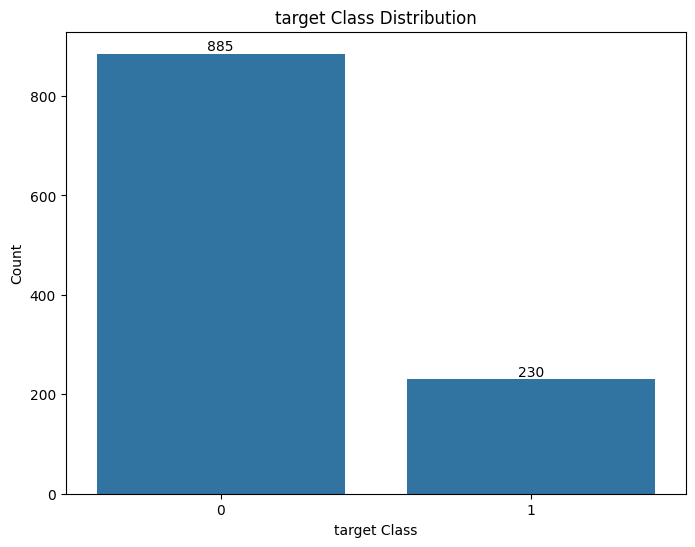

In [59]:
import seaborn as sns 

class DatasetAnalyzer:
    def __init__(self, df):
        
        self.df = df
        
    def check_target_balance(self, column, verbose):
        """
        Check if the dataset is balanced or unbalanced based on the specified column.

        Args:
        - column (str): The column name for which balance is checked.
        - verbose (bool): Whether to display the bar plot. Defaults to True.

        Returns:
        - pandas.DataFrame: DataFrame displaying counts and percentages.
        """
        column_value_counts = self.df[column].value_counts()
        column_percentage = column_value_counts / len(self.df[column]) * 100

        result_df = pd.DataFrame({'Count': column_value_counts, 'Percentage': column_percentage})
        result_df.index.name = f'{column} Values'

        if  verbose:
            plt.figure(figsize=(8, 6))
            ax = sns.barplot(x=result_df.index, y='Count', data=result_df.reset_index())
            plt.title(f'{column} Class Distribution')
            plt.xlabel(f'{column} Class')
            plt.ylabel('Count')

            for p in ax.patches:
                ax.annotate(format(p.get_height(), '.0f'),
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 5),
                            textcoords='offset points')

            plt.show()

        return result_df

    def check_dtypes_balance(self, verbose):
        """
        Plot data type counts of columns in a DataFrame using a bar plot.

        Returns:
        - None (displays the bar plot).
        """
        data_types = self.df.dtypes
        data_type_counts = data_types.value_counts().reset_index()
        data_type_counts.columns = ['Data Type', 'Count']

        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x='Data Type', y='Count', data=data_type_counts)

        plt.title('Data Types of Columns')
        plt.xlabel('Data Types')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        if verbose:
            for p in ax.patches:
                ax.annotate(format(p.get_height(), '.0f'),
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 5),
                            textcoords='offset points')

        plt.show()
        return data_type_counts
    
    def visualize_missing_values(self):
        """
        Visualize missing values in the DataFrame using a bar plot.

        Args:
        - df (pandas.DataFrame): The DataFrame to check for missing values.

        Returns:
        - None: Displays a bar plot showing the count of missing values in columns.
        """
        # Calculate percentage of missing values in the DataFrame
        missing_values = self.df.isnull().sum().sort_values(ascending=False)
        missing_values = missing_values[missing_values > 0]  # Select columns with missing values
        total_entries = len(self.df)  # Total number of entries in the DataFrame

        # Calculate percentage of missing values relative to the total dataset
        missing_values_percentage = (missing_values / total_entries) * 100

        # Plotting missing values as a percentage using Seaborn bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x=missing_values_percentage.index, y=missing_values_percentage.values)

        plt.title('Percentage of Missing Values in Columns')
        plt.xlabel('')  # Empty x-label to remove x-axis labels
        plt.ylabel('Percentage of Missing Values')
        plt.xticks([])  # Remove x-axis ticks and labels
        plt.tight_layout()
        plt.show()


da = DatasetAnalyzer(df_train)
result = da.check_target_balance(column='target',verbose=True)

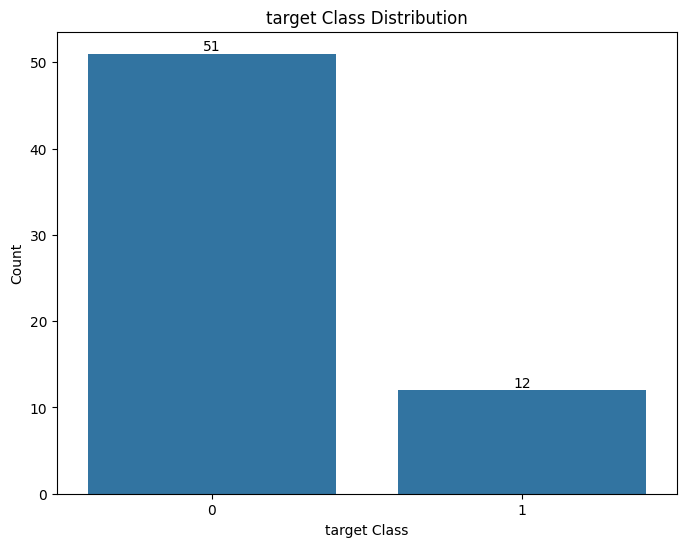

In [60]:
da = DatasetAnalyzer(df_test)
result = da.check_target_balance(column='target',verbose=True)

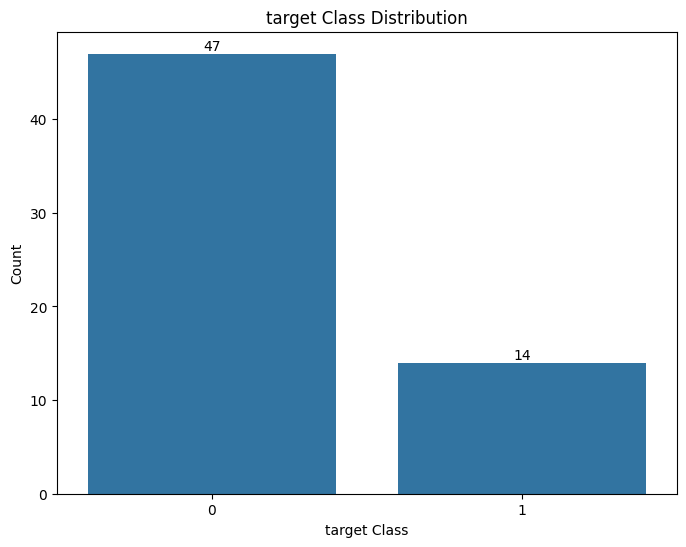

In [61]:
da = DatasetAnalyzer(df_val)
result = da.check_target_balance(column='target',verbose=True)